# PyTorch ANN for MNIST Digit Classification

## By: Mustafa Yildirim

Importing Libraries

In [1]:
import torch as t
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt

Preparing the Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(mnist_trainset.data.shape, mnist_testset.data.shape)

train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


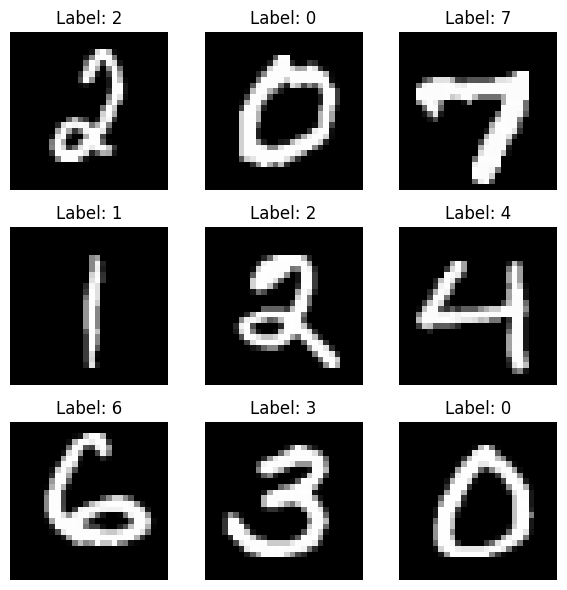

In [3]:
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(3, 3, figsize=(6,6))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Initializing the Model

In [4]:
class AnnModel(nn.Module):
    def __init__(self):
        super(AnnModel, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 64)
        self.final = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.final(x)
        return x

In [5]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model = AnnModel().to(device)

cross_entropy = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.001)

In [6]:
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AnnModel                                 [1, 10]                   --
├─Linear: 1-1                            [1, 128]                  100,480
├─ReLU: 1-2                              [1, 128]                  --
├─Linear: 1-3                            [1, 128]                  16,512
├─ReLU: 1-4                              [1, 128]                  --
├─Linear: 1-5                            [1, 64]                   8,256
├─ReLU: 1-6                              [1, 64]                   --
├─Linear: 1-7                            [1, 10]                   650
Total params: 125,898
Trainable params: 125,898
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.50
Estimated Total Size (MB): 0.51

Training the Model

In [7]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    
    correct = 0
    total = 0
    epoch_loss = 0

    for data in train_loader:
        X, y = data
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(X.view(X.size(0), -1))
        
        predictions = output.argmax(dim=1)
        correct += (predictions == y).sum().item()
        total += y.size(0)
        
        loss = cross_entropy(output, y)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_accuracy = (correct / total) * 100
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch: {epoch+1}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy:.2f}%')


Epoch: 1, Loss: 0.3326, Accuracy: 89.53%
Epoch: 2, Loss: 0.1766, Accuracy: 94.55%
Epoch: 3, Loss: 0.1414, Accuracy: 95.66%
Epoch: 4, Loss: 0.1213, Accuracy: 96.32%
Epoch: 5, Loss: 0.1111, Accuracy: 96.53%
Epoch: 6, Loss: 0.1019, Accuracy: 96.86%
Epoch: 7, Loss: 0.0945, Accuracy: 97.01%
Epoch: 8, Loss: 0.0866, Accuracy: 97.34%
Epoch: 9, Loss: 0.0822, Accuracy: 97.49%
Epoch: 10, Loss: 0.0802, Accuracy: 97.56%


Visualization of the train accuracy and loss

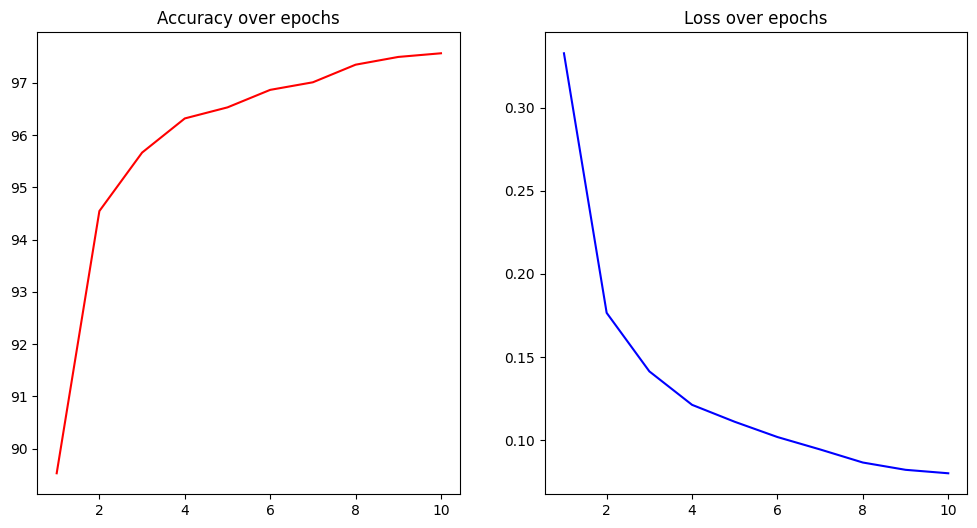

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Accuracy over epochs')
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='red')

plt.subplot(1, 2, 2)
plt.title('Loss over epochs')
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')

plt.legend
plt.show()

Testing the Model

In [9]:
correct = 0
total = 0

with t.no_grad():
    for data in test_loader:
        X, y = data
        X, y = X.to(device), y.to(device)
        
        output = model(X.view(-1, 28*28))
        
        for idx, i in enumerate(output):
            
            if t.argmax(i) == y[idx]:
                correct = correct + 1
            total = total + 1
print(f'acc: {round(correct/total, 3)}')        

acc: 0.972


Doing Predictions

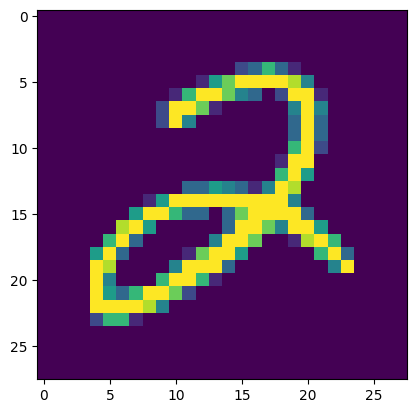

tensor(2, device='cuda:0')


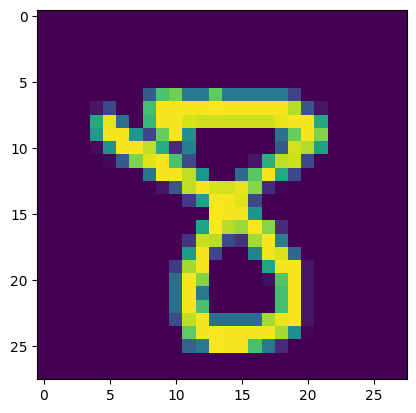

tensor(8, device='cuda:0')


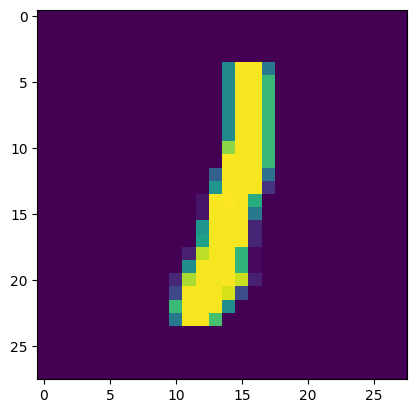

tensor(1, device='cuda:0')


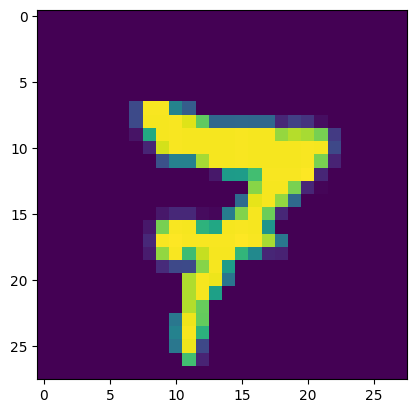

tensor(7, device='cuda:0')


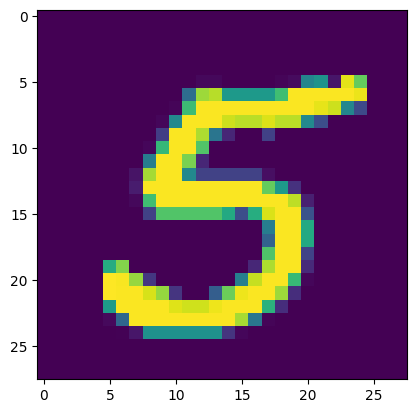

tensor(5, device='cuda:0')


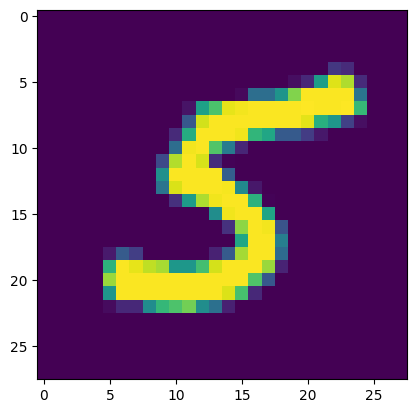

tensor(5, device='cuda:0')


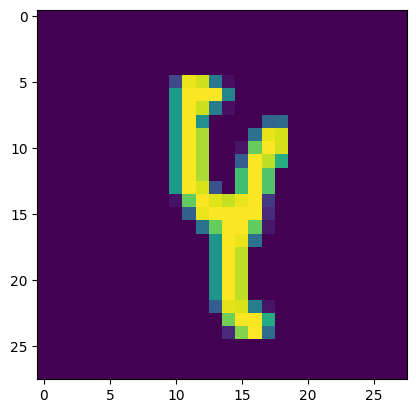

tensor(4, device='cuda:0')


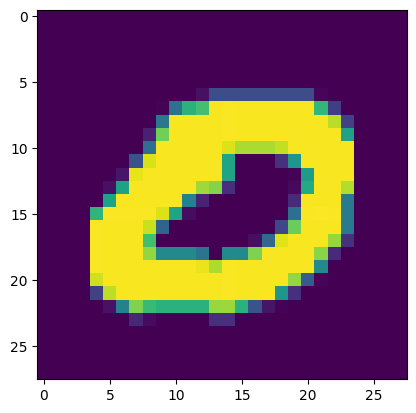

tensor(0, device='cuda:0')


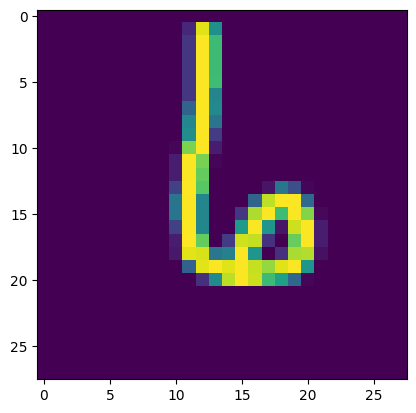

tensor(6, device='cuda:0')


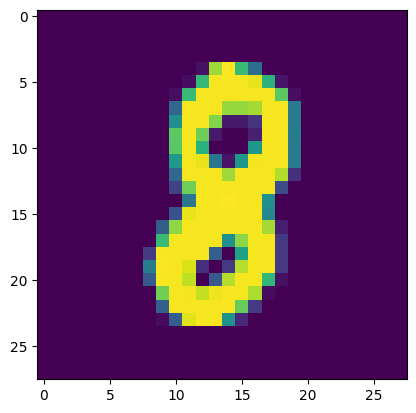

tensor(8, device='cuda:0')


In [10]:
for index in range(0, 10):
    plt.imshow(X[index].cpu().view(28, 28))
    plt.show()

    print(t.argmax(model(X[index].view(-1, 28*28))[0]))